https://github.com/SAISQUARE/raveendratal

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##  1. How to create partitions based on year and month
2022/01
2022/02
2022/03

on premises, traditional databases.
Date format: dd-mm-yyyy

spark date format: yyyy-MM-dd

**Data partitioning:** 

Is critical to data processing performance especially for large volume of data, Spark data partition is a way to split the data into multiple partitions so that you can execute transformations on multiple partitions in parallel which allows completing the job faster. Partitions are basic units of parallelism in Spark and RDDs, DataFrames and Datasets are collections of partitions. You can use methods like `repartition`, `coalesce`, `partitionBy` and `repartitionByRange` to control the partitioning of your data. Partitioning can also improve the performance of your queries by reducing data shuffling and enabling partition pruning.

PySpark partition is a way to split a large dataset into smaller datasets based on one or more partition keys. When you create a DataFrame from a file/table, based on certain parameters PySpark creates the DataFrame with a certain number of partitions in memory. This is one of the main advantages of PySpark DataFrame over Pandas DataFrame. Transformations on partitioned data run faster as they execute transformations parallelly for each partition.

In [ ]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
sc = SparkSession.builder.getOrCreate()

In [ ]:
sdf_emp = sc.read.csv("emp.csv", header = True, inferSchema = True)
sdf_emp.printSchema()

root
 |-- EMPNO: string (nullable = true)
 |-- ENAME: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- MGR: string (nullable = true)
 |-- HIREDATE: string (nullable = true)
 |-- SAL: string (nullable = true)
 |-- COMM: string (nullable = true)
 |-- DEPTNO: string (nullable = true)
 |-- UPDATED_DATE: string (nullable = true)



In [ ]:
sdf_emp.show(5)

+-----+------+--------+----+----------+----+----+------+------------+
|EMPNO| ENAME|     JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+------+--------+----+----------+----+----+------+------------+
| 7369| SMITH|   CLERK|7902|17-12-1980| 800|null|    20|  2022-01-01|
| 7499| ALLEN|SALESMAN|7698|20-02-1981|1600| 300|    30|  2022-01-01|
| 7521|  WARD|SALESMAN|7698|22-02-1981|1250| 500|    30|  2022-01-01|
| 7566| JONES| MANAGER|7839|04-02-1981|2975|null|    20|  2022-01-05|
| 7654|MARTIN|SALESMAN|7698|21-09-1981|1250|1400|    30|  2022-01-03|
+-----+------+--------+----+----------+----+----+------+------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import to_date
#change string to Date datetype
sdf_emp = sdf_emp.withColumn("HIREDATE", to_date("HIREDATE", "dd-MM-yyyy")).fillna({"HIREDATE":"9999-12-31"})
sdf_emp.show(5)
sdf_emp.printSchema()

+-----+------+--------+----+----------+----+----+------+------------+
|EMPNO| ENAME|     JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|
+-----+------+--------+----+----------+----+----+------+------------+
| 7369| SMITH|   CLERK|7902|1980-12-17| 800|null|    20|  2022-01-01|
| 7499| ALLEN|SALESMAN|7698|1981-02-20|1600| 300|    30|  2022-01-01|
| 7521|  WARD|SALESMAN|7698|1981-02-22|1250| 500|    30|  2022-01-01|
| 7566| JONES| MANAGER|7839|1981-02-04|2975|null|    20|  2022-01-05|
| 7654|MARTIN|SALESMAN|7698|1981-09-21|1250|1400|    30|  2022-01-03|
+-----+------+--------+----+----------+----+----+------+------------+
only showing top 5 rows

root
 |-- EMPNO: string (nullable = true)
 |-- ENAME: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- MGR: string (nullable = true)
 |-- HIREDATE: date (nullable = true)
 |-- SAL: string (nullable = true)
 |-- COMM: string (nullable = true)
 |-- DEPTNO: string (nullable = true)
 |-- UPDATED_DATE: string (nullable = true)



In [ ]:
#creating two year and month new columns base on hiredate date field
from pyspark.sql.functions import date_format
sdf_emp = (sdf_emp.withColumn("YEAR", date_format("HIREDATE", "yyyy"))
                  .withColumn("MONTH", date_format("HIREDATE", "MM")))
sdf_emp.show(5)
sdf_emp.printSchema()

+-----+------+--------+----+----------+----+----+------+------------+----+-----+
|EMPNO| ENAME|     JOB| MGR|  HIREDATE| SAL|COMM|DEPTNO|UPDATED_DATE|YEAR|MONTH|
+-----+------+--------+----+----------+----+----+------+------------+----+-----+
| 7369| SMITH|   CLERK|7902|1980-12-17| 800|null|    20|  2022-01-01|1980|   12|
| 7499| ALLEN|SALESMAN|7698|1981-02-20|1600| 300|    30|  2022-01-01|1981|   02|
| 7521|  WARD|SALESMAN|7698|1981-02-22|1250| 500|    30|  2022-01-01|1981|   02|
| 7566| JONES| MANAGER|7839|1981-02-04|2975|null|    20|  2022-01-05|1981|   02|
| 7654|MARTIN|SALESMAN|7698|1981-09-21|1250|1400|    30|  2022-01-03|1981|   09|
+-----+------+--------+----+----------+----+----+------+------------+----+-----+
only showing top 5 rows

root
 |-- EMPNO: string (nullable = true)
 |-- ENAME: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- MGR: string (nullable = true)
 |-- HIREDATE: date (nullable = true)
 |-- SAL: string (nullable = true)
 |-- COMM: string (nulla

In [ ]:
#Using PartitionBy with Two Columns creating partitions

#partitionBy() multiple columns
sdf_emp.write.option("header",True) \
             .partitionBy("YEAR","MONTH") \
             .mode("overwrite") \
             .csv("year-month-partitions")


## 2. How to handle or how to read variable/dynamic number of column data file

This dataset have multiple missing values:

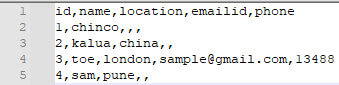



File with columns

File without columns

In [ ]:
sdf2 = sc.read.csv("exercise-2.csv", inferSchema = True)
sdf2.show()

+---+------+--------+----------------+-----+
|_c0|   _c1|     _c2|             _c3|  _c4|
+---+------+--------+----------------+-----+
| id|  name|location|         emailid|phone|
|  1|chinco|    null|            null| null|
|  2| kalua|   china|            null| null|
|  3|   toe|  london|sample@gmail.com|13488|
|  4|   sam|    pune|            null| null|
+---+------+--------+----------------+-----+



In [ ]:
sdf2 = sc.read.text("exercise-2.csv")
sdf2.show(truncate=False)

+-----------------------------------+
|value                              |
+-----------------------------------+
|id,name,location,emailid,phone     |
|1,chinco,,,                        |
|2,kalua,china,,                    |
|3,toe,london,sample@gmail.com,13488|
|4,sam,pune,,                       |
+-----------------------------------+



In [ ]:
from pyspark.sql.functions import split

#First split each record by ","
print("First split each record by ","") 
sdf2.withColumn("splittable_col", split("value", ",").alias("splittable_col")).show(truncate=False)

print("Dataframe after split data")
#drop the "value" column and keep the "splittable_col" and save the new df
sdf2 = sdf2.withColumn("splittable_col", split("value", ",").alias("splittable_col")).drop("value")
sdf2.show(truncate=False)

First split each record by  
+-----------------------------------+-----------------------------------------+
|value                              |splittable_col                           |
+-----------------------------------+-----------------------------------------+
|id,name,location,emailid,phone     |[id, name, location, emailid, phone]     |
|1,chinco,,,                        |[1, chinco, , , ]                        |
|2,kalua,china,,                    |[2, kalua, china, , ]                    |
|3,toe,london,sample@gmail.com,13488|[3, toe, london, sample@gmail.com, 13488]|
|4,sam,pune,,                       |[4, sam, pune, , ]                       |
+-----------------------------------+-----------------------------------------+

Dataframe after split data
+-----------------------------------------+
|splittable_col                           |
+-----------------------------------------+
|[id, name, location, emailid, phone]     |
|[1, chinco, , , ]                        |
|[2

In [ ]:
from pyspark.sql.functions import size, max

#get the length of each list record, upon to get the max value length
sdf2.select("splittable_col", size("splittable_col")).show(truncate=False)
max_column_length = sdf2.select(max(size("splittable_col"))).collect()[0][0]
print("Max columns length :", max_column_length)

+-----------------------------------------+--------------------+
|splittable_col                           |size(splittable_col)|
+-----------------------------------------+--------------------+
|[id, name, location, emailid, phone]     |5                   |
|[1, chinco, , , ]                        |5                   |
|[2, kalua, china, , ]                    |5                   |
|[3, toe, london, sample@gmail.com, 13488]|5                   |
|[4, sam, pune, , ]                       |5                   |
+-----------------------------------------+--------------------+

Max columns length : 5


In [ ]:
#Iter from 0 to max_value by each record and get the value of the each field from the list
#[id -> 0, name -> 1, location -> 2, emailid -> 3, phone -> 4]
#by each field create a new column with each value

for i in range(max_column_length):
  sdf2 = sdf2.withColumn("col" + str(i), sdf2["splittable_col"][i])

In [ ]:
print("After each iteration")
sdf2.show(truncate=False)

#drop the split column "splittable_col"
final_sdf = sdf2.drop("splittable_col")
final_sdf.show()

After each iteration
+-----------------------------------------+----+------+--------+----------------+-----+
|splittable_col                           |col0|col1  |col2    |col3            |col4 |
+-----------------------------------------+----+------+--------+----------------+-----+
|[id, name, location, emailid, phone]     |id  |name  |location|emailid         |phone|
|[1, chinco, , , ]                        |1   |chinco|        |                |     |
|[2, kalua, china, , ]                    |2   |kalua |china   |                |     |
|[3, toe, london, sample@gmail.com, 13488]|3   |toe   |london  |sample@gmail.com|13488|
|[4, sam, pune, , ]                       |4   |sam   |pune    |                |     |
+-----------------------------------------+----+------+--------+----------------+-----+

+----+------+--------+----------------+-----+
|col0|  col1|    col2|            col3| col4|
+----+------+--------+----------------+-----+
|  id|  name|location|         emailid|phone|
| 

## 3. How to skip first few rows from data file

Cleaning file with record with no meaningful data

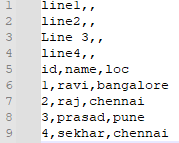




In [76]:
sdf = sc.read.csv("exercise-3.csv", header = True)
sdf.show()

+------+------+---------+
| line1|   _c1|      _c2|
+------+------+---------+
| line2|  null|     null|
|Line 3|  null|     null|
| line4|  null|     null|
|    id|  name|      loc|
|     1|  ravi|bangalore|
|     2|   raj|  chennai|
|     3|prasad|     pune|
|     4|sekhar|  chennai|
+------+------+---------+



In [85]:
rdd = sc.sparkContext.textFile("exercise-3.csv")
rdd.collect()
#rdd_final = rdd.zipWithIndex().filter( lambda pair: pair[1] > 3 ).map( lambda element: element[0].split(",") ).collect()

['line1,,',
 'line2,,',
 'Line 3,,',
 'line4,,',
 'id,name,loc',
 '1,ravi,bangalore',
 '2,raj,chennai',
 '3,prasad,pune',
 '4,sekhar,chennai']

`zipWithIndex()` returns a RDD of tuples where the first element of the tuple is the value and the second element is the index. The ordering is first based on the partition index and then the ordering of items within each partition. So the first item in the first partition gets index 0, and the last item in the last partition receives the largest index.

In [86]:
rdd.zipWithIndex().collect()

[('line1,,', 0),
 ('line2,,', 1),
 ('Line 3,,', 2),
 ('line4,,', 3),
 ('id,name,loc', 4),
 ('1,ravi,bangalore', 5),
 ('2,raj,chennai', 6),
 ('3,prasad,pune', 7),
 ('4,sekhar,chennai', 8)]

Ignore the row 1 to 4 filtering with the index 

In [89]:
rdd.zipWithIndex().filter( lambda row: row[1] > 3 ).collect()

[('id,name,loc', 4),
 ('1,ravi,bangalore', 5),
 ('2,raj,chennai', 6),
 ('3,prasad,pune', 7),
 ('4,sekhar,chennai', 8)]

Using a map function to only obtain the first elemen of the tuple and ignoring the index value

In [98]:
rdd_final = rdd.zipWithIndex().filter( lambda row: row[1] > 3 ).map( lambda row: row[0].split(",") )
rdd_final.collect()

[['id', 'name', 'loc'],
 ['1', 'ravi', 'bangalore'],
 ['2', 'raj', 'chennai'],
 ['3', 'prasad', 'pune'],
 ['4', 'sekhar', 'chennai']]

In [104]:
#Separate the columns names with the rest of the data
columns = rdd_final.first()
data = rdd_final.filter(lambda record: record != columns)

sdf = sc.createDataFrame(data, columns)
sdf.printSchema()
sdf.show()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- loc: string (nullable = true)

+---+------+---------+
| id|  name|      loc|
+---+------+---------+
|  1|  ravi|bangalore|
|  2|   raj|  chennai|
|  3|prasad|     pune|
|  4|sekhar|  chennai|
+---+------+---------+



## How to handle remove duplicate records based on updated date

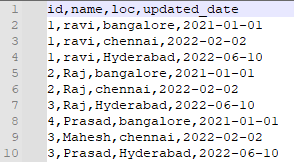


1.   `Disctinct(): `is used to return a new DataFrame containing the distinct rows in the original DataFrame1. It eliminates any rows that have the same values on all columns.
2.   `dropDuplicates() / drop_duplicates():` If you want to select distinct values on specific columns, you can use the dropDuplicates() function instead2. This function takes a list of columns as an argument and returns a new DataFrame with unique values on those columns

The difference between `distinct()` and dropDuplicates() in PySpark is that distinct() performs on all columns of the DataFrame and returns a new DataFrame with only unique rows, whereas dropDuplicates() performs on selected columns of the DataFrame and returns a new DataFrame with unique values on those columns

3.   window function with Row_number(): The row_number() function is a window function in PySpark that assigns a sequential number starting from 1 to each row in the result DataFrame12. This function is used with Window.partitionBy() which partitions the data into windows frames and orderBy() clause to sort the rows in each partition.
4.   groupBy with Count()

In [105]:
sdf = sc.read.csv("exercise-4.csv", header = True, inferSchema = True)
sdf.printSchema()
sdf.show()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- loc: string (nullable = true)
 |-- updated_date: date (nullable = true)

+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|bangalore|  2021-01-01|
|  1|  ravi|  chennai|  2022-02-02|
|  1|  ravi|Hyderabad|  2022-06-10|
|  2|   Raj|bangalore|  2021-01-01|
|  2|   Raj|  chennai|  2022-02-02|
|  3|   Raj|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
|  3|Mahesh|  chennai|  2022-02-02|
|  3|Prasad|Hyderabad|  2022-06-10|
+---+------+---------+------------+



In [108]:
#Remove the columns with the same id with dropDuplicates()
sdf.distinct().show()
#There aren't duplicate records

+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  2|   Raj|bangalore|  2021-01-01|
|  3|Prasad|Hyderabad|  2022-06-10|
|  1|  ravi|bangalore|  2021-01-01|
|  1|  ravi|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
|  3|   Raj|Hyderabad|  2022-06-10|
|  2|   Raj|  chennai|  2022-02-02|
|  1|  ravi|  chennai|  2022-02-02|
|  3|Mahesh|  chennai|  2022-02-02|
+---+------+---------+------------+



In [109]:
#Remove the columns with the same column "id" with dropDuplicates()
sdf.dropDuplicates(["id"]).show()

+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|bangalore|  2021-01-01|
|  2|   Raj|bangalore|  2021-01-01|
|  3|   Raj|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
+---+------+---------+------------+



remove duplicate records based on updated date considering the columns "updated_date" with the latest date


`orderBy()`: is used to sort a DataFrame based on one or more columns. It takes one or more columns as arguments and returns a new DataFrame sorted by the specified columns. By default, it sorts in ascending order, but you can also specify the sort order using the ascending parameter or the `desc()` method.

In [117]:
from pyspark.sql.functions import col

print("Before drop")
sdf.orderBy(col("updated_date").desc()).show()

print("after drop only maintaining the latest date")
sdf.orderBy(col("updated_date").desc()).dropDuplicates(["id"]).show()

Before drop
+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|Hyderabad|  2022-06-10|
|  3|   Raj|Hyderabad|  2022-06-10|
|  3|Prasad|Hyderabad|  2022-06-10|
|  1|  ravi|  chennai|  2022-02-02|
|  2|   Raj|  chennai|  2022-02-02|
|  3|Mahesh|  chennai|  2022-02-02|
|  1|  ravi|bangalore|  2021-01-01|
|  2|   Raj|bangalore|  2021-01-01|
|  4|Prasad|bangalore|  2021-01-01|
+---+------+---------+------------+

after drop only maintaining the latest date
+---+------+---------+------------+
| id|  name|      loc|updated_date|
+---+------+---------+------------+
|  1|  ravi|Hyderabad|  2022-06-10|
|  2|   Raj|  chennai|  2022-02-02|
|  3|   Raj|Hyderabad|  2022-06-10|
|  4|Prasad|bangalore|  2021-01-01|
+---+------+---------+------------+



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

sdf = sdf.withColumn("rowid", row_number().over(Window.partitionBy("id").orderBy(col("updated_date").desc())))
sdf.show()
sdf.filter("rowid = 1").show()

In [118]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

The `Window.partitionBy()` function in PySpark is used to create a WindowSpec object with the partitioning defined. It takes one or more columns as arguments and returns a WindowSpec object that can be used with window functions to perform calculations over a group of rows that share the same values on the partitioning columns.

In [125]:
windowSpec = Window.partitionBy("id").orderBy(col("updated_date").desc())

In [130]:
sdf = sdf.withColumn("rowid", row_number().over(windowSpec))
sdf.show()

+---+------+---------+------------+-----+
| id|  name|      loc|updated_date|rowid|
+---+------+---------+------------+-----+
|  1|  ravi|Hyderabad|  2022-06-10|    1|
|  1|  ravi|  chennai|  2022-02-02|    2|
|  1|  ravi|bangalore|  2021-01-01|    3|
|  2|   Raj|  chennai|  2022-02-02|    1|
|  2|   Raj|bangalore|  2021-01-01|    2|
|  3|   Raj|Hyderabad|  2022-06-10|    1|
|  3|Prasad|Hyderabad|  2022-06-10|    2|
|  3|Mahesh|  chennai|  2022-02-02|    3|
|  4|Prasad|bangalore|  2021-01-01|    1|
+---+------+---------+------------+-----+



In [131]:
sdf.filter(col("rowid") == 1).show()

+---+------+---------+------------+-----+
| id|  name|      loc|updated_date|rowid|
+---+------+---------+------------+-----+
|  1|  ravi|Hyderabad|  2022-06-10|    1|
|  2|   Raj|  chennai|  2022-02-02|    1|
|  3|   Raj|Hyderabad|  2022-06-10|    1|
|  4|Prasad|bangalore|  2021-01-01|    1|
+---+------+---------+------------+-----+

